<a href="https://colab.research.google.com/github/hallelujahylefay/limit_order_book/blob/efearase-patch-1/notebooks/Filltime%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, backend, constraints, initializers
from keras_self_attention import SeqSelfAttention


In [ ]:
df = pd.read_csv('truncated_LOB_data_BTC_USD_COINBASE.csv')

In [ ]:
def finder_of_fulfilment(df, column):
    time, indicator = [], []
    for i in range(len(df)):
        num = df[column].iloc[i]
        arr = df[df[column]>num][column].index
        time.append(pd.to_datetime(df['timestamp'].iloc[arr[arr>i][0]]) - pd.to_datetime(df['timestamp'].iloc[i])
                    if len(arr[arr>i]) else
                    pd.to_datetime('2023-10-03 00:00:00') - pd.to_datetime(df['timestamp'].iloc[i]))
        indicator.append(1 if len(arr[arr>i]) else 0)
    return time, indicator

In [ ]:
df['time'], df['indicator'] = finder_of_fulfilment(df, 'ask_prices_0')
df

,timestamp,bid_prices_0,ask_prices_0,bid_quantity_0,ask_quantity_0,bid_prices_1,ask_prices_1,bid_quantity_1,ask_quantity_1,bid_prices_2,...,bid_prices_3,ask_prices_3,bid_quantity_3,ask_quantity_3,bid_prices_4,ask_prices_4,bid_quantity_4,ask_quantity_4,time,indicator
0,2023-10-02 00:00:00.047811072,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.115522,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.287121920,1
1,2023-10-02 00:00:00.199801088,27995.45,27995.46,2.969115,0.171891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.135131904,1
2,2023-10-02 00:00:00.242750976,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27998.00,0.042005,0.500000,27993.73,27998.06,0.186802,0.161504,0 days 00:00:04.092182016,1
3,2023-10-02 00:00:00.303438848,27995.45,27995.46,2.969115,0.421891,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,0 days 00:00:04.031494144,1
4,2023-10-02 00:00:00.395410176,27995.45,27995.46,2.969115,0.420490,27994.28,27996.67,0.078016,0.020000,27994.26,...,27993.74,27997.99,0.042005,0.001200,27993.73,27998.00,0.186802,0.500000,0 days 00:00:03.939522816,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103081,2023-10-02 00:10:12.153671936,27968.27,27970.24,0.171501,0.020000,27968.26,27970.25,0.020000,0.053564,27967.98,...,27967.27,27971.29,0.271732,0.214506,27966.76,27971.32,0.452887,0.028795,0 days 23:49:47.846328064,0
103082,2023-10-02 00:10:12.154450944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.29,0.072000,0.214506,27967.27,27971.32,0.271732,0.028795,0 days 23:49:47.845549056,0
103083,2023-10-02 00:10:12.158212864,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.29,0.072000,0.214506,27967.28,27971.32,0.040000,0.028795,0 days 23:49:47.841787136,0
103084,2023-10-02 00:10:12.158674944,27968.28,27970.24,0.158101,0.020000,27968.27,27970.25,0.171501,0.053564,27968.26,...,27967.98,27971.28,0.072000,0.040000,27967.28,27971.29,0.040000,0.214506,0 days 23:49:47.841325056,0


In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time'] = (df['time']).dt.total_seconds().astype(int)
df = df.iloc[0:-140]

In [ ]:
df_to_plot = df[['indicator', 'time']]
N = len(df_to_plot)
F_of_t = []

for time in range(max(df['time'])):
    num_executed = len(df_to_plot[df_to_plot['time']<time])
    prob = num_executed/N
    F_of_t.append(prob)

S_of_t = 1 - np.array(F_of_t)

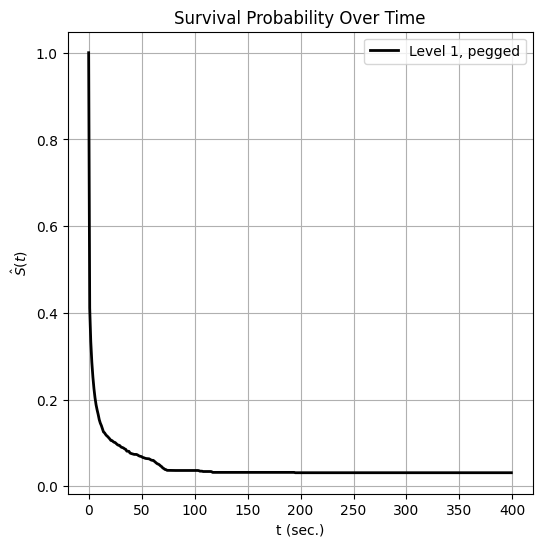

In [ ]:
t = np.linspace(0, max(df['time']), max(df['time']))

plt.figure(figsize=(6, 6))
plt.plot(t[:400], S_of_t[:400], linewidth=2, label='Level 1, pegged', color='black')
plt.xlabel('t (sec.)')
plt.ylabel('$\hat{S}(t)$')
plt.title('Survival Probability Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Make some features and drop useless columns
pd.options.mode.chained_assignment = None

df['vol_imbalance'] = (df['bid_quantity_0'] - df['ask_quantity_0'])/(df['bid_quantity_0'] + df['ask_quantity_0'])
df['microprice'] = ((df['bid_prices_0']*df['bid_quantity_0']+df['ask_prices_0']*df['ask_quantity_0'])
                    /(df['bid_quantity_0'] + df['ask_quantity_0']))

In [ ]:
target = [] #create target S(execution_time)
for i in range(len(df)):
    target.append(S_of_t[df['time'].iloc[i]-1])

df['target'] = target

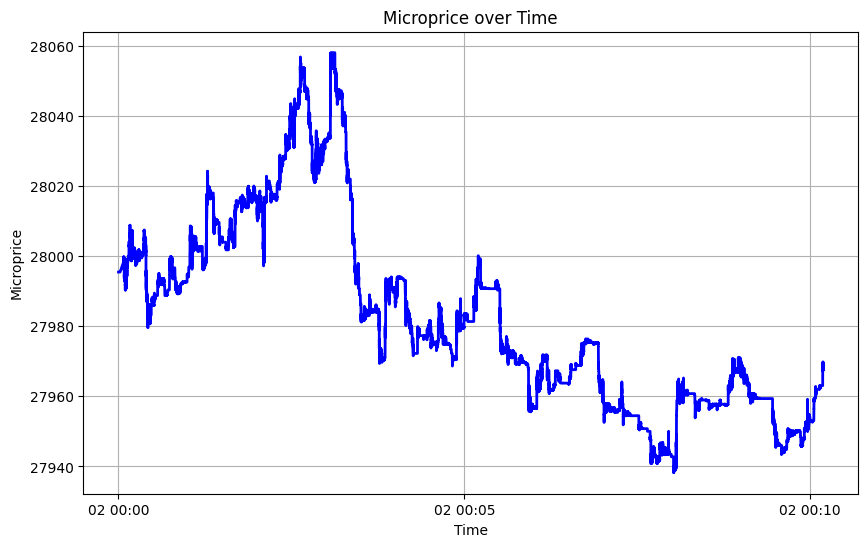

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['microprice'], color='blue', linewidth=2, label='Microprice')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Microprice')
plt.title('Microprice over Time')

# Displaying the grid
plt.grid(True)

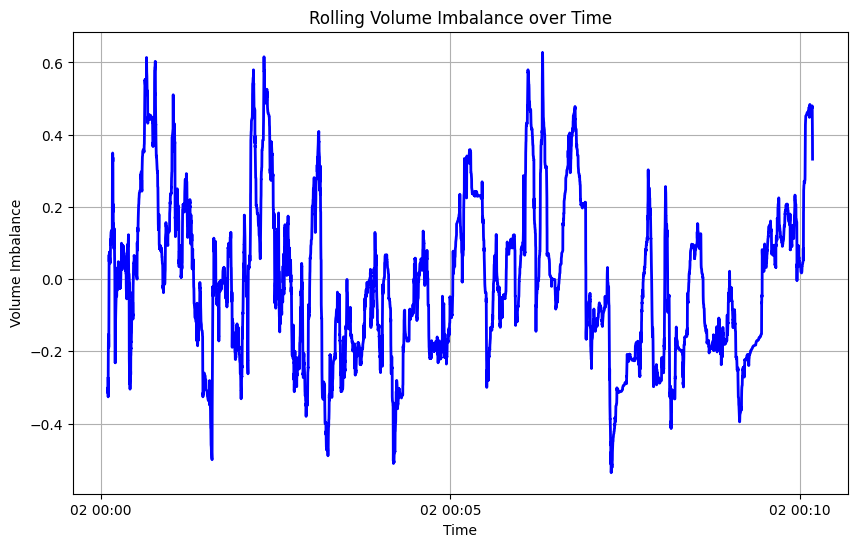

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['vol_imbalance'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Rolling Volume Imbalance')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Volume Imbalance')
plt.title('Rolling Volume Imbalance over Time')

# Displaying the grid
plt.grid(True)

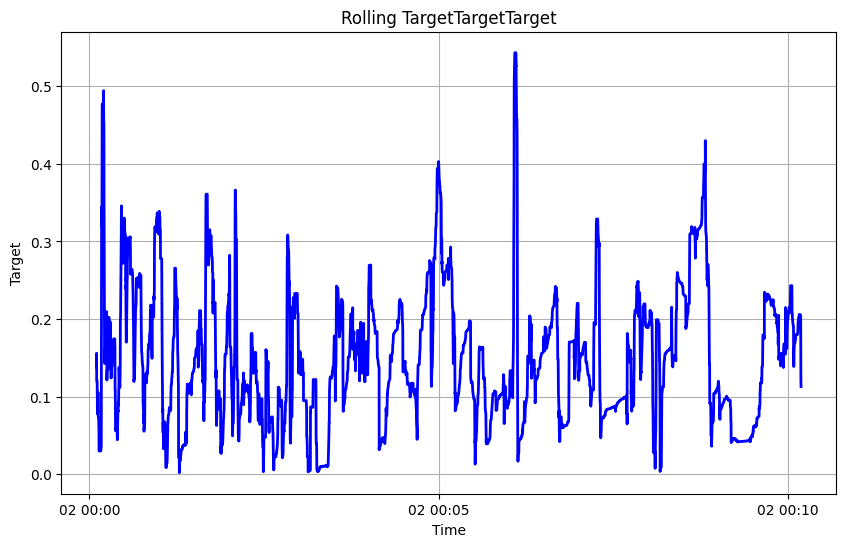

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the microprice with a blue line
plt.plot(df['timestamp'], df['target'].rolling(1000).mean(), color='blue',
         linewidth=2, label='Target thing')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Rolling TargetTargetTarget')

# Displaying the grid
plt.grid(True)

In [ ]:
df.set_index('timestamp', drop=True, inplace=True)

X = df.drop(columns=['time', 'indicator', 'target'])
Y = df['target']

# Simplified Staff (does not work)

In [ ]:
input_shape = X.shape[1:]  # Assuming X is your data
steps = 1  # You need to determine the appropriate number of steps based on your data
new_input_shape = (input_shape[0], steps)
encoder_input = Input(shape=input_shape)
encoder_reshape = Reshape(new_input_shape)(encoder_input)
encoder_conv1 = Conv1D(32, kernel_size=2, activation='relu')(encoder_reshape)
encoder_lstm = LSTM(32, activation='relu')(encoder_conv1)
latent_dim = 32
encoder_output = Dense(latent_dim)(encoder_lstm)

encoder_model = Model(encoder_input, encoder_output)

# Define the decoder
decoder_input = Input(shape=(latent_dim,))
decoder_dense1 = Dense(32, activation='relu')(decoder_input)
decoder_reshape = Reshape((1, 32))(decoder_dense1)
decoder_conv1 = Conv1D(32, kernel_size=3, activation='relu', padding='same')(decoder_reshape)
output_dim = 32
decoder_output = Dense(output_dim, activation='sigmoid')(decoder_conv1)

decoder_model = Model(decoder_input, decoder_output)

# Combine the encoder and decoder into an autoencoder
autoencoder_input = Input(shape=input_shape)
encoded = encoder_model(autoencoder_input)
decoded = decoder_model(encoded)
autoencoder_model = Model(autoencoder_input, decoded)

# Compile the model
autoencoder_model.compile(optimizer='adam', loss='mse')

# Train the model
autoencoder_model.fit(X, Y, epochs=3, batch_size=32)

# Some experiements (model is almost ready monotonicity change is needed or S(t) to f(t) transition)

In [215]:
# Define the DCC layer (updated version)
class DilatedCausalConvolution(layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate):
        super().__init__()
        self.query_conv = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                        dilation_rate=dilation_rate, padding='same', activation='sigmoid')
        self.key_conv = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                      dilation_rate=dilation_rate, padding='causal', activation='sigmoid')
        self.value_conv = layers.Conv1D(filters=filters, kernel_size=kernel_size,
                                        dilation_rate=dilation_rate, padding='causal', activation='sigmoid')

    def call(self, inputs):
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)
        return query, key, value

# Define the Transformer block (updated version)
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, d_model):
        super().__init__()
        self.multi_head_attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    def call(self, query, key, value):
        attn_output = self.multi_head_attention(query, key, value)
        proj_output = tf.concat(attn_output, axis=0)
        return proj_output

# Define the encoder using the DCC and Transformer block (updated version)
def create_encoder(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model):
    inputs = layers.Input(shape=input_shape)
    dcc_layer = DilatedCausalConvolution(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate)
    query, key, value = dcc_layer(inputs)
    transformer_block = TransformerBlock(num_heads=num_heads, d_model=d_model)
    transformer_output = transformer_block(query, key, value)
    model = models.Model(inputs=inputs, outputs=transformer_output)
    #print(model.weights)
    return model

# Define the monotonic decoder (updated version)
def monotonic_constraint(weight_matrix):
    # Constraint for monotonicity: weights must be non-negative
    return tf.where(weight_matrix < -0.0, tf.zeros_like(weight_matrix), weight_matrix)

class CustomDense(layers.Layer):
    def __init__(self, units, activation='sigmoid', **kwargs):
        super(CustomDense, self).__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Ensure the last dimension of input_shape is an integer
        last_dim = input_shape[-1] if isinstance(input_shape[-1], int) else input_shape[-1].value

        # Constraint for the weights to be non-negative for monotonicity
        self.kernel = self.add_weight(
            name='kernel',
            shape=(last_dim, self.units),
            initializer='zeros',
            constraint=monotonic_constraint,
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        super(CustomDense, self).build(input_shape)

    def call(self, inputs):
        # Apply monotonic constraint during the forward pass
        return self.activation(tf.matmul(inputs, self.kernel) + self.bias)


# def create_monotonic_decoder(input_shape, output_shape):
#     inputs = layers.Input(shape=input_shape)

#     # Custom dense layer with non-negative weights and sigmoid activation to ensure output is between 0 and 1
#     outputs = CustomDense(output_shape, activation='sigmoid')(inputs)

#     model = models.Model(inputs=inputs, outputs=outputs)
#     return model
class CustomDecoder(tf.keras.layers.Layer):
    def __init__(self, input_dim, units, activation='sigmoid', num_layers=5, **kwargs):
        super(CustomDecoder, self).__init__(**kwargs)
        self.num_layers = num_layers
        self.dense_layers = [CustomDense(units, activation=activation) for _ in range(num_layers)]
        self.input_dim = input_dim

    def build(self, input_shape):
        # First layer needs to know input shape
        self.dense_layers[0].build((None, self.input_dim))

    def call(self, inputs):
        x = inputs
        for layer in self.dense_layers:
            x = layer(x)
        return x



# Combine the encoder and decoder to create the full model (updated version)
def create_full_model(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model, output_shape):
    encoder_inputs = layers.Input(shape=input_shape)
    encoder = create_encoder(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model)
    encoder_output = encoder(encoder_inputs)

    encoder_output_dim = encoder_output.shape[-1]  # This should be an integer

    decoder = CustomDecoder(input_dim=encoder_output_dim, units=units, activation='sigmoid')
    decoder_output = decoder(encoder_output)
    flat_output = tf.keras.layers.Flatten()(decoder_output)
    final_output = tf.keras.layers.Dense(1)(flat_output)
    full_model = models.Model(inputs=encoder_inputs, outputs=final_output)

    return full_model

In [216]:
# Expand dimensions of X to add the channel dimension if needed
X_expanded = np.expand_dims(X, axis=1)  # Shape becomes (99601, 22, 1)
train_ds = tf.data.Dataset.from_tensor_slices((X_expanded, Y)).batch(32)

# Define model parameters
input_shape = (1, 22)  # 22 features per 1 timestamp
filters = 64
units = 32
kernel_size = 32
dilation_rate = 32
num_heads = 3
d_model = 64
output_shape = 1

initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = create_full_model(input_shape, filters, kernel_size, dilation_rate, num_heads, d_model, output_shape)
model.compile()
loss_object = tf.keras.losses.MeanAbsoluteError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [217]:
@tf.function
def train_step(X, y):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(X, training=True)
    loss = loss_object(y, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  train_loss(loss)

In [ ]:
EPOCHS = 50
previous_loss = 0
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()

  for features, s in train_ds:
    train_step(features, s)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}.2f, '
  )
  if not abs((train_loss.result() - previous_loss)/train_loss.result())< 10**(-5):
    pass

Epoch 1, Loss: 0.22947394847869873.2f, 
Epoch 2, Loss: 0.1947171986103058.2f, 
Epoch 3, Loss: 0.19554246962070465.2f, 
Epoch 4, Loss: 0.1934686303138733.2f, 


In [ ]:
Y_pred = model.predict(X_expanded)
Y_pred.mean()

In [ ]:
plt.plot(Y_pred)